# [STATISTICAL APPROACH FOR MAKING PREDICTIONS OF CONFIRMED INFECTION AND DEATHS ON CORONA VIRUS](https://assets.tue.nl/fileadmin/content/pers/2020/03%20March/TUe%20-%20Technical_Report_Prediction_Corona_Virus.pdf)

I will be reimplementing the model proposed by researchers from TU Eindhoven in this notebook. They proposed to fit a simple sigmoid function to each of the measurements of a country:
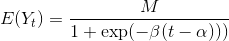
with M the maximal number of cases, 𝛼 the number of days at which the expected number of counts is half way the maximum,and 𝛽 > 0 the growth parameter.

**Special caution should be taken with exponential models such as these though... I am not saying that this is the ideal approach, I am merely replicating their study**

**!!! IMPORTANT: The public test set overlaps with the training set !!! We have to filter out data from after 11/03 in order to get an accurate public LB score**

In [ ]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_log_error
import warnings; warnings.filterwarnings('ignore')

# Load in our data

In [ ]:
train = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-1/train.csv')
train['Date'] = pd.to_datetime(train['Date'])
test = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-1/test.csv')
test['Date'] = pd.to_datetime(test['Date'])
sub = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-1/submission.csv')
sub['ForecastId'] = test['ForecastId'].values
sub = sub.set_index('ForecastId', drop=True)
train

# Remove overlap between train and test set

In [ ]:
# Only use data up to 11/03 to get a public LB score
print(len(train))
eval = train[train["Date"] >= min(test['Date'])]
train = train[train["Date"] < min(test['Date'])]
print(len(train))

# Fit sigmoid model for each country / region combination

In [ ]:
def sigmoid(t, M, beta, alpha):
    return M / (1 + np.exp(-beta * (t - alpha)))

sigmoid_models = {}
def forecast(data, steps, key=None):
    if sum(data) == 0 or sum(data != 0) <= 3:
        return [data[-1]] * steps
    
    filtered_data = data[data > 0]
    
    try:
        def error(params):
            M, beta, alpha = params
            return np.sqrt(mean_squared_log_error(filtered_data, sigmoid(list(range(sum(data == 0), len(data))), M, beta, alpha)))
        res = opt.minimize(error, x0=[1000, 0.25, 100])
        M, beta, alpha = res.x
        sigmoid_models[key] = (M, beta, alpha)
        return np.clip(sigmoid(list(range(len(data), len(data) + steps)), M, beta, alpha), 0, None).astype(int)
    except:
        try:
            popt, pcov = opt.curve_fit(sigmoid, list(range(sum(data == 0), len(data))), 
                                       filtered_data, maxfev=10000, p0=[1000, 0.25, 100])
            M, beta, alpha = popt
            sigmoid_models[key] = (M, beta, alpha)
            return np.clip(sigmoid(list(range(len(data), len(data) + steps)), M, beta, alpha), 0, None).astype(int)
        except:
            print(key)
            return [data[-1]] * steps
    


for country in tqdm_notebook(np.unique(train['Country/Region'])):
    country_data = train[(train['Country/Region'] == country)]
    country_data = country_data.sort_values(by='Date')
    if country not in ['US', 'China', 'Canada', 'Australia', 'France', 'United Kingdom', 'Netherlands', 'Denmark', 'Cruise Ship']:
        country_test_data = test[test['Country/Region'] == country].sort_values(by='Date')
        sub.loc[country_test_data['ForecastId'], 'ConfirmedCases'] = forecast(country_data['ConfirmedCases'].values, len(country_test_data), key=(country, np.NaN, 'ConfirmedCases'))
        sub.loc[country_test_data['ForecastId'], 'Fatalities'] = forecast(country_data['Fatalities'].values, len(country_test_data), key=(country, np.NaN, 'Fatalities'))
    else:
        for region in np.unique(country_data['Province/State']):
            region_data = country_data[country_data['Province/State'] == region]
            region_data = region_data.sort_values(by='Date')
            
            region_test_data = test[(test['Country/Region'] == country) & (test['Province/State'] == region)].sort_values(by='Date')
            sub.loc[region_test_data['ForecastId'], 'ConfirmedCases'] = forecast(region_data['ConfirmedCases'].values, len(region_test_data), key=(country, region, 'ConfirmedCases'))
            sub.loc[region_test_data['ForecastId'], 'Fatalities'] = forecast(region_data['Fatalities'].values, len(region_test_data), key=(country, region, 'Fatalities'))

# Plot some of our fitted models

In [ ]:
random_key_ix = list(np.random.choice(list(range(len(sigmoid_models))), 22, replace=False))
random_keys = [list(sigmoid_models.keys())[ix] for ix in random_key_ix] + [('Austria', np.NaN, 'ConfirmedCases'), ('Italy', np.NaN, 'ConfirmedCases'), ('Belgium', np.NaN, 'ConfirmedCases')]
f, ax = plt.subplots(5, 5, figsize=(20, 20))
for i, key in enumerate(random_keys):
    country, region, task = key
    
    filtered_data = train[(train['Country/Region'] == country)]
    if not pd.isnull(region):
        filtered_data = filtered_data[(filtered_data['Province/State'] == region)]
        
    filtered_eval_data = eval[(eval['Country/Region'] == country)]
    if not pd.isnull(region):
        filtered_eval_data = filtered_eval_data[(filtered_eval_data['Province/State'] == region)]
        
    x = list(range(len(country_data)))
    x += list(range(len(x), len(x) + 25))
    
    M, beta, alpha = sigmoid_models[key]
    ax[i // 5][i % 5].plot(x, sigmoid(x, M, beta, alpha))
    ax[i // 5][i % 5].scatter(list(range(len(filtered_data))), filtered_data[task].values)
    ax[i // 5][i % 5].scatter(list(range(len(filtered_data), len(filtered_data) + len(filtered_eval_data))), filtered_eval_data[task].values)
    ax[i // 5][i % 5].set_title('{} ({}, {})'.format(task, country, region), fontsize=8)
plt.show()

# Calculate public LB score

In [ ]:
eval1 = eval.merge(test, how='left', on=['Date', 'Country/Region', 'Province/State'])
eval1 = eval1.merge(sub, left_on=['ForecastId'], right_index=True)
score_c = np.sqrt(mean_squared_log_error(eval1['ConfirmedCases_x'].values, eval1['ConfirmedCases_y']))
score_f = np.sqrt(mean_squared_log_error(eval1['Fatalities_x'].values, eval1['Fatalities_y']))

print(f'score_c: {score_c}, score_f: {score_f}, mean: {np.mean([score_c, score_f])}')

In [ ]:
plt.scatter(np.log1p(eval1['ConfirmedCases_x'].values), np.log1p(eval1['ConfirmedCases_y']))

In [ ]:
plt.scatter(np.log1p(eval1['Fatalities_x'].values), np.log1p(eval1['Fatalities_y']))

# Write away our submission

In [ ]:
sub.to_csv('submission.csv')